Artificial Intelligence 2020/21Agent and Infrastructure implementation Homework 1 assigned 19/10/2021 due 27/10/21(Recommended: on a python jupyter notebook)

Implement “Infastructure” the main{} that runs the “simulation” of the agents Agenti acting in the world:- State/world-situation representation- main(S(t), Ai(t))=S(t+1);main(S(t)){loop{for i : Ai(t)=action(Agenti,S(t)); S(t+1)= for i : apply action Ai(t) on S(t)}}Implement agents that use the  various Heuristic Search Algorithms...
Instantiate your infrastructure with a single agent to solve a puzzle of your choice (no TICTACTOE...)Write a report describing your implementations and a statistics over sample runs .

Your statistic should compare the performance of different agents running different Search Algo and/or different heuristic evaluations

Instantiate your infrastructure with two  agents to play a board game (recommended chess)(as before main(S(t), Ai(t))=S(t+1); but now agent1 does nothing when t=even and plays a move when t=odd, and viceversa for agent2.Instructions and recommendations:1.Keep your implementation as modular as possible, keeping various components  (infrastructure, state representation and computation of agent actions effects, agents, search algo, Heuristic functions...) well separated from each other and/or encapsulated...For example, it should be possible , given an implementation that plays chess, to use it to play a different game by simply changing the game model (representation and functions).2. You can import existing libraries or other implementations (clearly state, when you do so, your source) as long as  you clearly distinguish what  you haveimported from what you have created yourself.Grading will  highly depend on how smart is the modularity of your implementation and will consider the originality of what you turn in (see point 2above)

# Puzzle Solver - Homework 1 - Author Andrea Serafini 277048
A Python program has been implemented in order to solve  a generic problem, the program provides the functions and the generalized data structure in order to make a good level of abstraction and make a flexible mechanism for an easy implementation of different puzzle.
For computation time reasons in this homework has been implemented an 8-puzzle solver. this tipe of puzzle allowed me to collect more data in reasonable time. The performance of the different search algorithm have been collected in table and bar charts for an easy comparison of the results.

In [1]:
# avoid recursion limit errors
import sys
sys.setrecursionlimit(10000)

In [2]:
import random
import heapq
import math
import sys
import time
from collections import defaultdict, deque, Counter
from itertools import combinations
from IPython.display import clear_output
import timeit

#import numpy as np
#import pandas as pd

# Data Structure

In [3]:
# The node object represent a generic node of the search tree
# each node has a parent , a state, an action and a path_cost

class Node:
    
    #constructor
    def __init__ (self, state, parent = None, action = None, path_cost = 0):
        self.__dict__.update (state = state, parent = parent, action = action, path_cost = path_cost)
        
    #representation
    def __repr__(self):
        return '<{}>'.format(self.state)
    #lenght
    def __len__(self):
        return 0 if self.parent is None else (1+ len(self.parent))
    #less than
    def __lt__(self,node):
        return self.path_cost < node.path_cost
 

In [4]:
#
# Problem 
#
class Problem(object):
    def __init__(self, initial=None, goal=None, **kwds): 
        self.__dict__.update(initial=initial, goal=goal, **kwds) 
        
    def actions(self, state):  
        raise NotImplementedError
    def result(self, state, action):
        raise NotImplementedError
    def is_goal(self, state):        
        return state == self.goal
    def action_cost(self, s, a, s1):
        return 1
    def h(self, node):              
        return 0
    
    def __str__(self):
        return '{}({!r}, {!r})'.format(
            type(self).__name__, self.initial, self.goal)

In [5]:
#fail is used to stop the search because the search alg cant find the solution
fail = Node('fail', path_cost=math.inf)
# cutoff node is used
cutoff  = Node('cutoff',  path_cost=math.inf) 

In [6]:
#generate child nodes  
def explore_childs(problem, node):
    s = node.state
    for action in problem.actions(s):
        #from a state s and an action a the problem go to state s1
        s1 = problem.result(s, action)
        cost = node.path_cost + problem.action_cost(s, action, s1)
        yield Node(s1, node, action, cost)

#sequence actions to reach a node        
def path_actions(node):
    if node.parent is None:
        return []  
    return path_actions(node.parent) + [node.action]

#sequence of states 
def path_states(node):
    if node in (cutoff, fail, None): 
        return []
    return path_states(node.parent) + [node.state]   


In [7]:

class HeapQueue:
    #A queue in which the item with minimum f(item) is always popped first.

    def __init__(self, items=(), key=lambda x: x): 
        self.key = key
        self.items = [] # a heap of (score, item) pairs
        for item in items:
            self.add(item)
         
    def add(self, item):
        pair = (self.key(item), item)
        heapq.heappush(self.items, pair)

   #Pop and return the item with min f(item) value.
    def pop(self):
        return heapq.heappop(self.items)[1]
    
    def top(self): return self.items[0][1]

    def __len__(self): return len(self.items)

In [8]:
class Stats():

    #constructor
    def __init__ (self, initial, final, explored, path_cost,time,name):
        self.__dict__.update (initial = initial, final = final, explored = explored, path_cost = path_cost, time = time, name = name)
    
    def get_stats(self,stats):
        return stats

In [9]:
stats=[]
def report (problem,exploredCount,time,node,name):         
    print ('Initial State:'+ str(problem.initial)+' | '+'Explored Nodes:'+ str(exploredCount)+' | '+'Path Cost:'+ str(node.path_cost)+' | '+'Elapsed Time:'+ str(time)[:6]+'|'+'\n Final State:'+' | '+str(node.state))
    stats.append(Stats(str(problem.initial),str(node.state),str(exploredCount),str(node.path_cost),str(time)[:6],name))

def launcher(searchers, problems):
    for searcher in searchers:
        print('********************************************************************************')
        print(searcher.__name__ + ':')
        for p in problems:
            soln = searcher(p)

In [10]:
## Search Alg ##

##BFS##


def best_first_search(problem, f, name = 'best_first_search'):
    exploredCount = 0
    t0 = time.time()
    #Search nodes with minimum f(node) value first.
    node = Node(problem.initial)
    horizon = HeapQueue([node], key=f)
    explored = {problem.initial: node}
    while horizon:
        node = horizon.pop()
        exploredCount= exploredCount+1 
        if problem.is_goal(node.state):
            t1 = time.time() - t0
            report (problem,exploredCount,t1, node,name )
            return node
        for child in explore_childs(problem, node):
            s = child.state
            if s not in explored or child.path_cost < explored[s].path_cost:
                explored[s] = child
                horizon.add(child)
                
    #print ('Fail')            
    return fail
def g(n): 
    """Return the path cost to arrive at node n"""
    return n.path_cost

def greedy_bfs(problem, h=None, name= 'greedy_bfs'):
    """Search nodes with minimum h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=h, name= 'greedy_bfs')

def uniform_cost_search(problem):
    "Search nodes with minimum path cost first."
    return best_first_search(problem, f=g, name ='uniform_cost_search')

def breadth_first_bfs(problem):
    return best_first_search(problem, f=len, name = 'breadth_first_bfs' )

def astar_search(problem, h=None ,name = 'astar_search'):
    #Search nodes with minimum f(n) = g(n) + h(n).
    h = h or problem.h
    return best_first_search(problem, f=lambda n: g(n) + h(n), name = name)



In [11]:

# EightPuzzle class

class EightPuzzle(Problem):
    """ The problem of sliding tiles numbered from 1 to 8 on a 3x3 board,
    where one of the squares is a blank, trying to reach a goal configuration.
    A board state is represented as a tuple of length 9, where the element at index i 
    represents the tile number at index i, or 0 if for the empty square, e.g. the goal:
        1 2 3
        4 5 6 ==> (1, 2, 3, 4, 5, 6, 7, 8, 0)
        7 8 _
    """

    def __init__(self, initial, goal=(1, 2, 3, 4, 5, 6, 7, 8, 0)):
        assert getInvCount(initial) % 2 == getInvCount(goal) % 2 # Parity check
        self.initial, self.goal = initial, goal
    
    def actions(self, state):
        """The indexes of the squares that the blank can move to."""
        moves = ((1, 3),    (0, 2, 4),    (1, 5),
                 (0, 4, 6), (1, 3, 5, 7), (2, 4, 8),
                 (3, 7),    (4, 6, 8),    (7, 5))
        blank = state.index(0)
        return moves[blank]
    
    def result(self, state, action):
        """Swap the blank with the square numbered `action`."""
        s = list(state)
        blank = state.index(0)
        s[action], s[blank] = s[blank], s[action]
        return tuple(s)
    
    def h1(self, node):
        """The misplaced tiles heuristic."""
        return hamming_distance(node.state, self.goal)
    
    def h2(self, node):
        """The Manhattan heuristic."""
        X = (0, 1, 2, 0, 1, 2, 0, 1, 2)
        Y = (0, 0, 0, 1, 1, 1, 2, 2, 2)
        return sum(abs(X[s] - X[g]) + abs(Y[s] - Y[g])
                   for (s, g) in zip(node.state, self.goal) if s != 0)
    
    def h(self, node): return self.h2(node)
    
    
def hamming_distance(A, B):
    "Number of positions where vectors A and B are different."
    return sum(a != b for a, b in zip(A, B))
    

def getInvCount(arr):
    inv_count = 0
    empty_value = 0
    for i in range(0, 9):
        for j in range(i + 1, 9):
            if arr[j] != empty_value and arr[i] != empty_value and arr[i] > arr[j]:
                inv_count += 1
    return inv_count
    
    
def board8(board, fmt=(3 * '{} {} {}\n')):
    "A string representing an 8-puzzle board"
    return fmt.format(*board).replace('0', '_')

In [12]:
e1 = EightPuzzle((1, 4, 2, 0, 7, 5, 3, 6, 8))
e2 = EightPuzzle((0, 1, 2, 3, 4, 5, 6, 7, 8))
e3 = EightPuzzle((4, 0, 2, 5, 1, 3, 7, 8, 6))
e4 = EightPuzzle((7, 2, 4, 5, 0, 6, 8, 3, 1))
e5 = EightPuzzle((8, 6, 7, 2, 5, 4, 3, 0, 1))
e6 = EightPuzzle((2, 1, 3, 5, 4, 6, 7, 8, 0))
e7 = EightPuzzle((1, 2, 4, 3, 8, 6, 7, 5, 0))

problems = [e1, e2, e3, e4, e5,e6,e7]
#problems = [e7]

In [13]:
def astar_misplaced_tiles(problem): return astar_search(problem, h = problem.h1,name ='astar_misplaced_tiles')
def astar_manhattan(problem): return astar_search(problem, h = problem.h2, name ='astar_manhattan')
def greedy_bfs_hamming(problem): return greedy_bfs(problem, h = problem.h, name = 'Greedy_BFS_hamming')
searchers = [greedy_bfs_hamming,
             breadth_first_bfs,
             uniform_cost_search,
             astar_misplaced_tiles,
             astar_manhattan]

#searchers = [breadth_first_bfs]

In [14]:
launcher (searchers,problems)

********************************************************************************
greedy_bfs_hamming:
Initial State:(1, 4, 2, 0, 7, 5, 3, 6, 8) | Explored Nodes:69 | Path Cost:31 | Elapsed Time:0.0019|
 Final State: | (1, 2, 3, 4, 5, 6, 7, 8, 0)
Initial State:(0, 1, 2, 3, 4, 5, 6, 7, 8) | Explored Nodes:959 | Path Cost:66 | Elapsed Time:0.0250|
 Final State: | (1, 2, 3, 4, 5, 6, 7, 8, 0)
Initial State:(4, 0, 2, 5, 1, 3, 7, 8, 6) | Explored Nodes:84 | Path Cost:7 | Elapsed Time:0.0020|
 Final State: | (1, 2, 3, 4, 5, 6, 7, 8, 0)
Initial State:(7, 2, 4, 5, 0, 6, 8, 3, 1) | Explored Nodes:14275 | Path Cost:74 | Elapsed Time:0.4336|
 Final State: | (1, 2, 3, 4, 5, 6, 7, 8, 0)
Initial State:(8, 6, 7, 2, 5, 4, 3, 0, 1) | Explored Nodes:1560 | Path Cost:75 | Elapsed Time:0.0435|
 Final State: | (1, 2, 3, 4, 5, 6, 7, 8, 0)
Initial State:(2, 1, 3, 5, 4, 6, 7, 8, 0) | Explored Nodes:323 | Path Cost:16 | Elapsed Time:0.0084|
 Final State: | (1, 2, 3, 4, 5, 6, 7, 8, 0)
Initial State:(1, 2, 4, 3, 8,

In [15]:
len(stats)

35

In [16]:
stats[0].initial

'(1, 4, 2, 0, 7, 5, 3, 6, 8)'

In [17]:
stats[0].explored

'69'

In [18]:
import matplotlib.pyplot as plt
def plot_problem(stats,problem,expl=False):
    plt.rcParams["figure.figsize"] = (15,3)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    x_values = []
    y_values = []  
    for s in range (len(stats)):
        if str(problem.initial) == str(stats[s].initial):
            x_values.append(str(stats[s].name)+'\n'+str(stats[s].initial))
            if expl:
                y_values.append(float(stats[s].explored))
            else:
                y_values.append(float(stats[s].time))
    ax.bar(x_values,y_values)
    plt.show()
    
def plot_all_problem(stats,problems,expl = False):
    for p in range(len(problems)):
        plot_problem(stats,problems[p], expl)

# Time Comparing
As we can observe from the following plot the the greedy best first search is usually the best performing search algorithm, the other good algorithm ar the a*star_search with the Manhattan and Misplaced_tiles Heuristics. The Breadth and Uniform Cost Search are the worst performing tested search alghoritm.

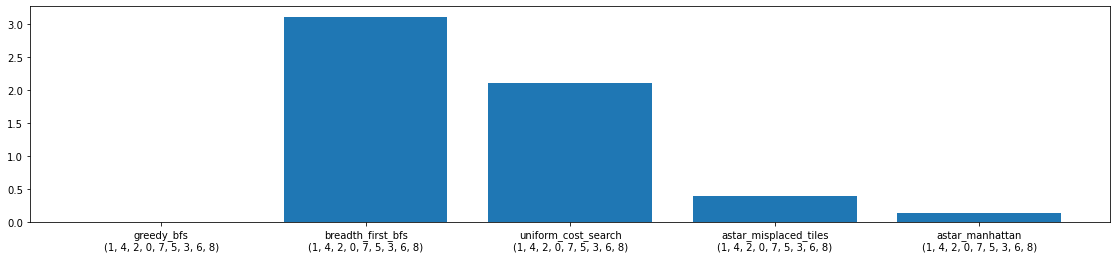

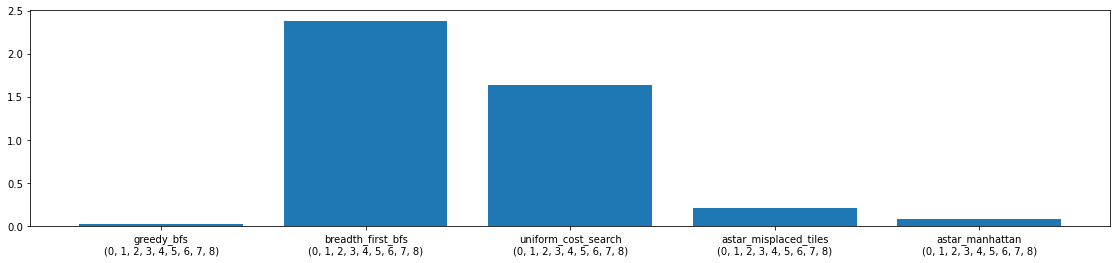

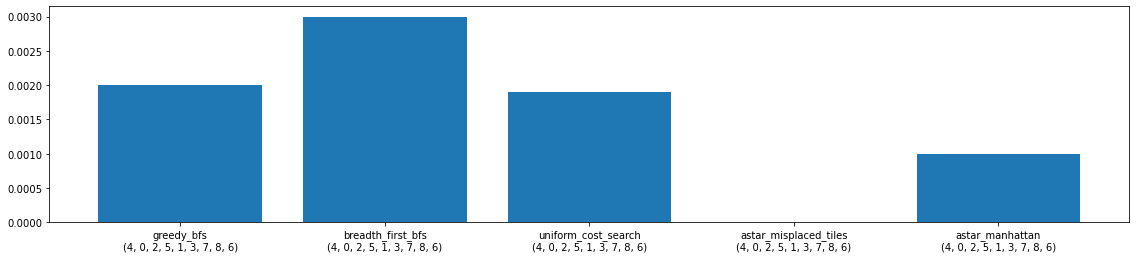

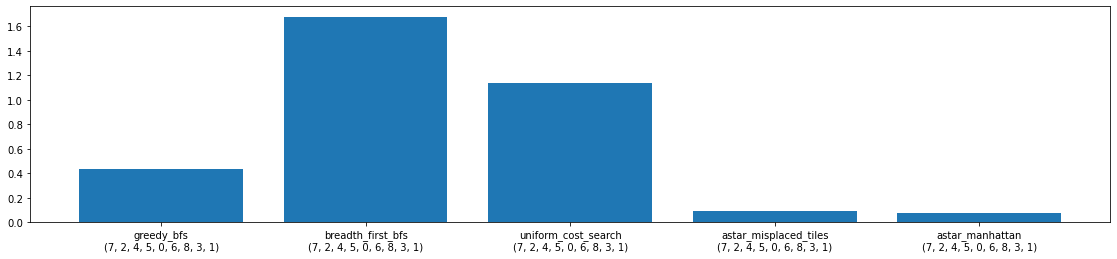

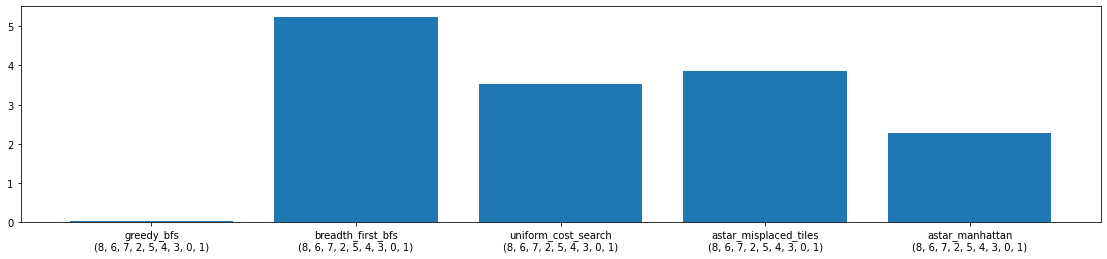

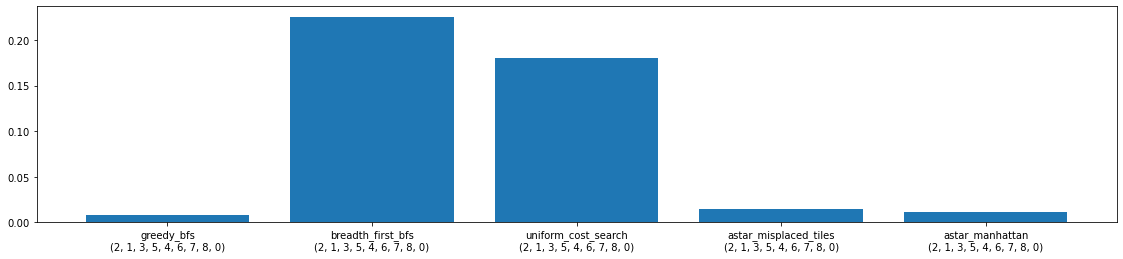

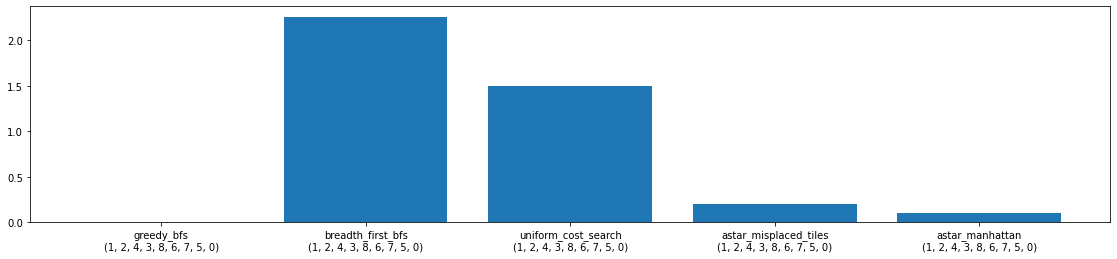

In [19]:

plot_all_problem(stats,problems,False)

# Explored Node Comparing

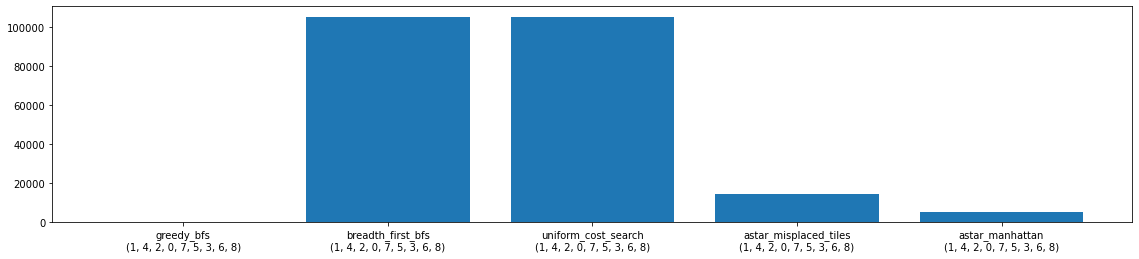

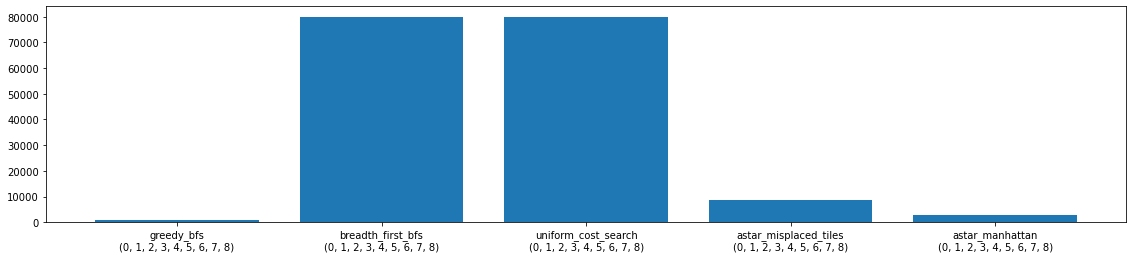

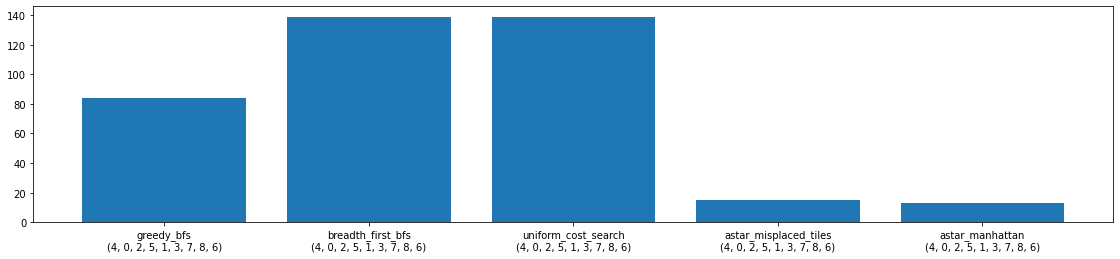

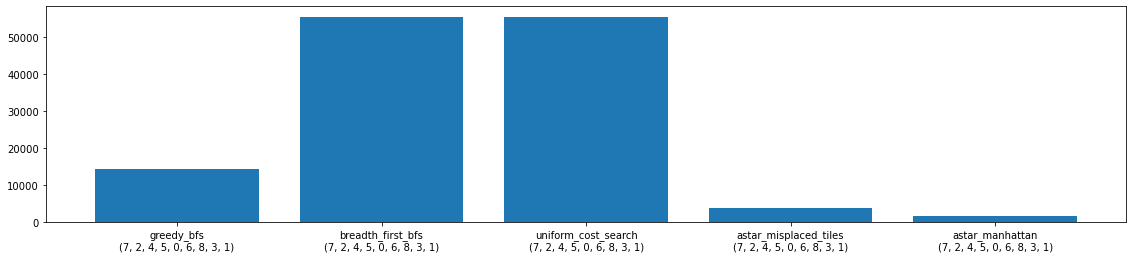

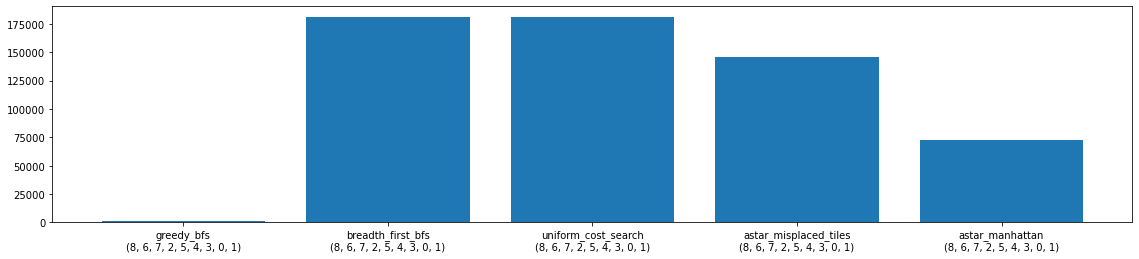

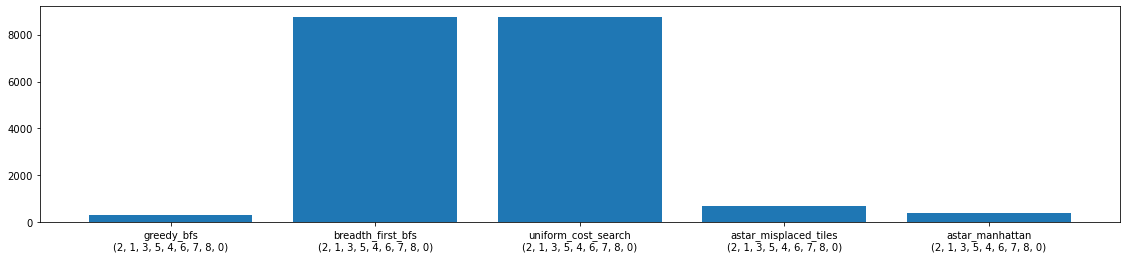

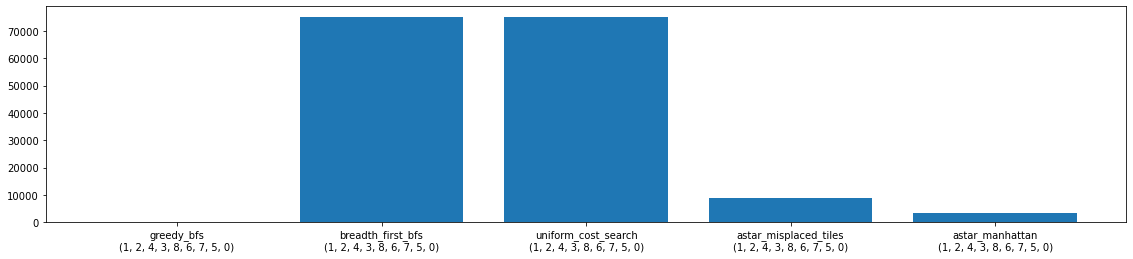

In [20]:
plot_all_problem(stats,problems,True)